In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

### X
level_name - one hot, target encoding

company - one hot, target encoding

title - word embedding, standardize somehow

location - one hot, country/state

years_exp - none

### A

race

gender

how to interpret NA?

### Y

salary

log(salary)

why log? being 10k off for individual that makes 60k means a lot more than being 10k off for individual that makes 600k

In [3]:
df = pd.read_csv('data/main-processed.tsv', sep='\t')
df['log_tc'] = df['tc'].apply(lambda x: np.log(x))

In [4]:
df['tag'].value_counts()

Full Stack                        16106
Distributed Systems (Back-End)    14007
API Development (Back-End)         9874
Web Development (Front-End)        4384
ML / AI                            3449
                                  ...  
Windows Developer                     1
Youtube                               1
Fintech                               1
SSD firmware                          1
camera sw                             1
Name: tag, Length: 1324, dtype: int64

<AxesSubplot:xlabel='yoe_total', ylabel='tc'>

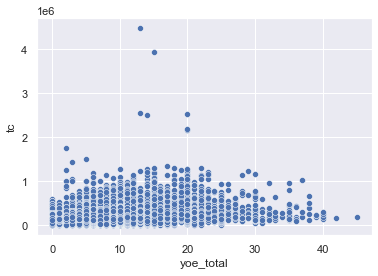

In [5]:
sns.scatterplot(x='yoe_total', y='tc', data=df)

<AxesSubplot:xlabel='yoe_total', ylabel='log_tc'>

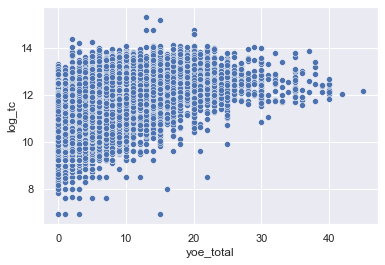

In [6]:
sns.scatterplot(x='yoe_total', y='log_tc', data=df)

In [7]:
df['company'].value_counts()

Amazon                  7213
Google                  3946
Microsoft               3927
Facebook                2584
Apple                   1217
                        ... 
Molex                      1
SimSpace                   1
Gerson Lehrman Group       1
Hoxton Analytics           1
General Assembly           1
Name: company, Length: 2963, dtype: int64

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer


import category_encoders as ce

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        #print(X[0:5])
        # try:
        #     print(X.columns)
        # except:
        #     pass
        self.shape = X.shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self


In [10]:
X = df.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1)
y = df['log_tc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
pl = Pipeline([
    ('debug-1', Debug()),
    ('ct', ColumnTransformer([
        ('impute', SimpleImputer(strategy='median'), ['yoe_total']),
        #('onehot', OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist'), ['company', 'location', 'level_name']),
        ('target', ce.TargetEncoder(), ['company', 'location', 'level_name']),
    ], remainder='drop')),
    #('debug-2', Debug()),
    #('normalize', Normalizer()),
    ('debug-3', Debug()),
    ('reg', LinearRegression())
])

In [12]:
pl.fit(X_train, y_train)

(52263, 16)
(52263, 4)


Pipeline(steps=[('debug-1', Debug()),
                ('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['yoe_total']),
                                                 ('target', TargetEncoder(),
                                                  ['company', 'location',
                                                   'level_name'])])),
                ('debug-3', Debug()), ('reg', LinearRegression())])

In [13]:
pl.score(X_test, y_test)

(13066, 16)
(13066, 4)


0.7291448978493648

In [14]:
pl.named_steps['reg'].coef_

array([0.02792763, 0.41670694, 0.73306675, 0.3449265 ])

In [15]:
pl.named_steps['reg'].intercept_

-6.088898256288227

In [ ]:
def continuous_demo_dist(X, A='gender', steps = 100):
    results = defaultdict(list)

    X = X.copy()
    X['predicted'] = pl.predict(X)
    bins = np.linspace(X['predicted'].min(), X['predicted'].max(), steps)

    for v in X[A].unique():
        results[v] = [(X[X[A] == v]['predicted'] > y_bin).mean() for y_bin in bins]
    results['bins'] = bins
    
    return results

In [16]:
def continuous_demo(X, A='gender', steps = 100):
    results = defaultdict(list)

    X = X.copy()
    X['predicted'] = pl.predict(X)
    bins = np.linspace(X['predicted'].min(), X['predicted'].max(), steps)

    for v in X[A].unique():
        results[v] = [(X[X[A] == v]['predicted'] > y_bin).mean() for y_bin in bins]
    results['bins'] = bins
    
    return results

In [17]:
X

,company,location,date,level_name,tag,yoe,yoe_total,title,work_arrangement,education,ethnicity,gender,other,track,country,state
0,Twitch,"San Francisco, CA",2022-05-04,L4,NaN,0.0,0.0,Software Engineer,Office,NaN,NaN,NaN,NaN,Software Engineer,United States,California
1,Atlassian,"Bangalore, KA, India",2022-05-04,P4,Distributed Systems (Back-End),2.0,7.0,Software Engineer,Remote,NaN,NaN,NaN,NaN,Software Engineer,India,Karnataka
2,Dell,"Bangalore, KA, India",2022-05-04,Software Engineer II,Embedded,3.0,3.0,Software Engineer 2,Hybrid,NaN,NaN,NaN,NaN,Software Engineer,India,Karnataka
3,Walmart Global Tech,"Sunnyvale, CA",2022-05-04,Senior Software Engineer,NaN,0.0,2.0,Senior Software Engineer,Office,Doctorate (PhD),NaN,NaN,I think they considered my PhD experience in t...,Software Engineer,United States,California
4,Carvana,"Atlanta, GA",2022-05-04,II,Web Development (Front-End),1.0,4.0,Software Engineer Ii,Remote,Bachelors degree,White,Female,NaN,Software Engineer,United States,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65324,Blackhawk Network,"Pittsburgh, PA",2019-12-16,Staff,Full Stack,3.0,15.0,Software Engineer,Office,NaN,NaN,Female,NaN,Software Engineer,United States,Pennsylvania
65325,Apple,"Cupertino, CA",2019-12-16,ICT3,ML / AI,1.0,1.0,Software Engineer,Office,Doctorate (PhD),NaN,Male,PhD,Software Engineer,United States,California
65326,Google,"New York, NY",2019-12-16,L3,Full Stack,0.0,0.0,Software Engineer,Office,NaN,NaN,NaN,NaN,Software Engineer,United States,New York
65327,Rapid7,"Boston, MA",2019-12-16,Lead Software Engineer,Distributed Systems (Back-End),2.0,11.0,Software Engineer,Office,NaN,NaN,Male,NaN,Software Engineer,United States,Massachusetts


In [18]:
X_us = X[X['country'] == 'United States']
X_cali = X[X['state'] == 'California']
X_sf = X[X['location'] == 'San Francisco, CA']

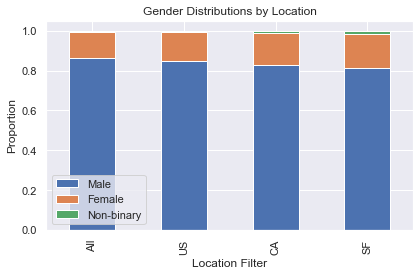

In [20]:
dfs = [X, X_us, X_cali, X_sf]
gender_table = pd.concat([df['gender'].value_counts(normalize=True) for df in dfs], axis=1).T.drop('Other', axis=1)
gender_table.index = ['All', 'US', 'CA', 'SF']
gender_table.plot(kind='bar', stacked=True)
plt.title("Gender Distributions by Location")
plt.ylabel("Proportion")
plt.xlabel("Location Filter")
plt.tight_layout()
plt.savefig('vis/dsc-167-2/gender_dist.png')

In [59]:
#.unstack().plot.bar(stacked=True)

Male          0.864060
Female        0.128620
Non-binary    0.007297
Other         0.000023
Name: gender, dtype: float64

In [60]:
X_us['gender'].value_counts(normalize=True)

Male          0.848342
Female        0.143750
Non-binary    0.007877
Other         0.000031
Name: gender, dtype: float64

In [61]:
all_locs = continuous_demo(X) 
us = continuous_demo(X_us)
cali = continuous_demo(X_cali)
sf = continuous_demo(X_sf)

(65329, 16)
(65329, 4)
(49950, 16)
(49950, 4)
(18281, 16)
(18281, 4)
(5326, 16)
(5326, 4)


In [105]:
np.subtract(us['Male'], us['Female']).sum() / 100

0.009213016858046636

In [106]:
np.subtract(cali['Male'], cali['Female']).sum() / 100

0.01812209179516581

In [107]:
np.subtract(sf['Male'], sf['Female']).sum() / 100

0.03872816433186991

In [62]:
x_axis = np.arange(0, 1, .01)

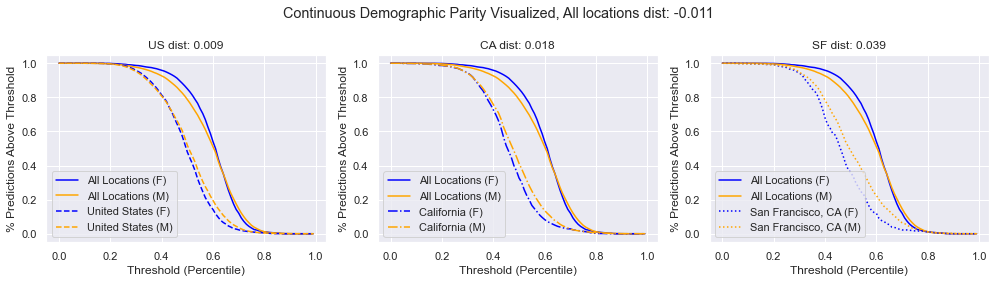

In [122]:
fig, ax = plt.subplots(1,3, figsize = (14,4))

ax[0].plot(x_axis, all_locs['Female'], label='All Locations (F)', linestyle='-', c='blue')
ax[0].plot(x_axis, all_locs['Male'], label ='All Locations (M)', linestyle='-', c='orange')
ax[0].plot(x_axis, us['Female'], label='United States (F)', linestyle='--', c='blue')
ax[0].plot(x_axis, us['Male'], label ='United States (M)', linestyle='--', c='orange')
ax[0].set_xlabel("Threshold (Percentile)")
ax[0].set_ylabel("% Predictions Above Threshold")
ax[0].set_title(f"US dist: {np.subtract(us['Male'], us['Female']).sum() / 100:.3f}")
ax[0].legend()

ax[1].plot(x_axis, all_locs['Female'], label='All Locations (F)', linestyle='-', c='blue')
ax[1].plot(x_axis, all_locs['Male'], label ='All Locations (M)', linestyle='-', c='orange')
ax[1].plot(x_axis, cali['Female'], label='California (F)', linestyle='-.', c='blue')
ax[1].plot(x_axis, cali['Male'], label ='California (M)', linestyle='-.', c='orange')
ax[1].set_xlabel("Threshold (Percentile)")
ax[1].set_ylabel("% Predictions Above Threshold")
ax[1].set_title(f"CA dist: {np.subtract(cali['Male'], cali['Female']).sum() / 100:.3f}")
ax[1].legend()

ax[2].plot(x_axis, all_locs['Female'], label='All Locations (F)', linestyle='-', c='blue')
ax[2].plot(x_axis, all_locs['Male'], label ='All Locations (M)', linestyle='-', c='orange')
ax[2].plot(x_axis, sf['Female'], label='San Francisco, CA (F)', linestyle=':', c='blue')
ax[2].plot(x_axis, sf['Male'], label ='San Francisco, CA (M)', linestyle=':', c='orange')
ax[2].set_xlabel("Threshold (Percentile)")
ax[2].set_ylabel("% Predictions Above Threshold")
ax[2].set_title(f"SF dist: {np.subtract(sf['Male'], sf['Female']).sum() / 100:.3f}")
ax[2].legend()

fig.suptitle(f"Continuous Demographic Parity Visualized, All locations dist: {np.subtract(all_locs['Male'], all_locs['Female']).sum() / 100:.3f}")

plt.tight_layout()
plt.savefig("./vis/dsc-167-2/demo_parity.png")

In [24]:
from sklearn.metrics import mean_squared_error

def bgl_mse(X, y, A='gender'):
    results = defaultdict(float)

    X = X.copy()
    y = y.copy()
    
    X['predicted'] = pl.predict(X)
    for v in X[A].unique():
        X_grp = X[X[A] == v]
        if len(X_grp):
            y_grp = y[X_grp.index]
            results[v] = mean_squared_error(X_grp['predicted'], y_grp)
    
    return results

In [25]:
def bgl_r2(X, y, A='gender'):
    results = defaultdict(float)

    X = X.copy()
    y = y.copy()
    for v in X[A].unique():
        X_grp = X[X[A] == v]
        if len(X_grp):
            y_grp = y[X_grp.index]
            results[v] = pl.score(X_grp, y_grp)
    
    return results

In [26]:
bgl_mse(X_test, y_test)

(13066, 16)
(13066, 4)


defaultdict(float,
            {'Female': 0.12505698783804342,
             'Male': 0.132743008405337,
             'Non-binary': 0.05736871079122871,
             'Other': 0.01525332084289814})

In [27]:
X_test['predicted'] = pl.predict(X_test)

(13066, 16)
(13066, 4)


In [28]:
X_test.groupby('gender')['predicted'].mean()

gender
Female        11.975611
Male          11.939969
Non-binary    11.953525
Other         11.932824
Name: predicted, dtype: float64